In [96]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

# 한글 폰트 설정
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)    

In [2]:
# 데이터 불러오기
cs = pd.read_csv('L사_고객정보.csv')
gd = pd.read_csv('L사_상품정보.csv')
tr = pd.read_csv('L사_거래정보.csv')

# 간단한 데이터 처리후 데이터 병합
gd.pd_c = gd.pd_c.astype(str).str.zfill(4) # 상품과 거래 데이터의 pd_c 컬럼의 데이터 유형이 서로 달라 맞춰줌. 자리수까지도 맞춰줘야 함. 
df = pd.merge(tr, cs).merge(gd, on='pd_c')
df.de_dt = df.de_dt.astype(str).astype('datetime64') # 날짜정보를 담고 있는 de_dt 컬럼의 데이터 유형이 정수이기 때문
df

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,21922,104999,3,A03,0182,2019-09-20,12:41,10900,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
1,39423,105124,10,A03,0182,2019-09-20,17:26,21800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
2,39423,89469,2,A03,0182,2019-09-01,03:32,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
3,39423,88436,1,A03,0182,2019-08-30,17:15,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
4,18362,50872,3,A03,0182,2019-07-15,09:46,31600,4,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582304,53632,75835,1,A01,0258,2019-08-14,10:00,77040,2,M,50,Computers,Computer Accessories,Printer Inks / Toners
582305,1499,92574,4,A01,1303,2019-09-04,08:09,29000,1,F,50,Sport Fashion,Women's Climbing Clothing,Women's Climbing Vests
582306,58443,103525,1,A01,0263,2019-09-18,10:30,568000,1,F,30,Computers,Computers / Laptops,Tablet PCs
582307,21232,103476,1,A01,0263,2019-09-18,01:38,362500,1,F,30,Computers,Computers / Laptops,Tablet PCs


# data 전처리

In [3]:
# 구매건수, 구매금액 이상치 제거
df = df.drop([166601,237521,230723])

# 구매금액이 0이 아닌데 구매건수가 0인 경우 1로 대체
df['buy_ct'] = np.where(df.buy_ct == 0, 1, df.buy_ct)

# 구매금액이 0인데 구매건수가 0이 아닌 경우 와 구매금액과 구매건수가 둘다 0인경우 삭제
df =df.query('buy_am != 0')

# RFM 세분화

In [5]:
# R(recency) 구하기
# 최종 구매일 다음날을 기준으로 계산 
now = df.de_dt.max()+pd.DateOffset(days=1)

# method chaining (multi-line)
R = (df.groupby('clnt_id')['de_dt']
           .agg(lambda x,y: (y - x).min().days, now).reset_index()
           .rename(columns={'de_dt':'recency'})
          )

R

,clnt_id,recency
0,2,32
1,9,17
2,12,38
3,20,1
4,23,3
...,...,...
11261,72373,15
11262,72400,23
11263,72410,12
11264,72423,14


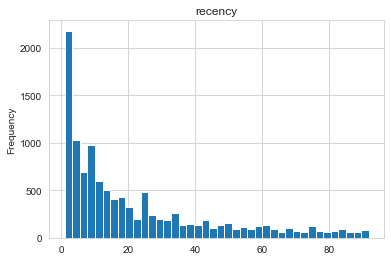

In [7]:
R.recency.plot.hist(bins=40)
plt.title('recency')
plt.show()

In [8]:
# F(frequency) 구하기
F = df.groupby('clnt_id')['trans_id'].agg([
    ('frequency', lambda x : x.nunique())]).reset_index()
F

,clnt_id,frequency
0,2,6
1,9,7
2,12,1
3,20,7
4,23,9
...,...,...
11261,72373,9
11262,72400,4
11263,72410,16
11264,72423,2


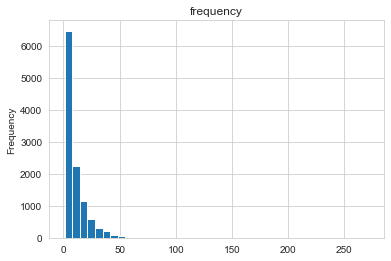

In [9]:
F.frequency.plot.hist(bins=40)
plt.title('frequency')
plt.show()

In [10]:
# M(monetary) 구하기
M = df.groupby('clnt_id')['buy_am'].agg([('monetary', np.sum)]).reset_index()
M

,clnt_id,monetary
0,2,157100
1,9,339941
2,12,29900
3,20,238580
4,23,202964
...,...,...
11261,72373,1038950
11262,72400,302710
11263,72410,463670
11264,72423,499500


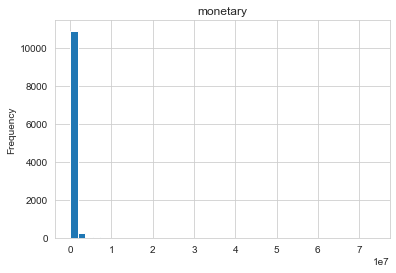

In [11]:
M.monetary.plot.hist(bins=40)
plt.title('monetary')
plt.show()

In [12]:
RFM = R.merge(F).merge(M);RFM

,clnt_id,recency,frequency,monetary
0,2,32,6,157100
1,9,17,7,339941
2,12,38,1,29900
3,20,1,7,238580
4,23,3,9,202964
...,...,...,...,...
11261,72373,15,9,1038950
11262,72400,23,4,302710
11263,72410,12,16,463670
11264,72423,14,2,499500


In [13]:
# 점수부여
RFM['R'] = pd.qcut(RFM['recency'], q=5, labels=range(5,0,-1)).astype(int)
RFM['F'] = pd.qcut(RFM['frequency'], q=5, labels=range(1,6)).astype(int)
RFM['M'] = pd.qcut(RFM['monetary'], q=5, labels=range(1,6)).astype(int)
RFM

,clnt_id,recency,frequency,monetary,R,F,M
0,2,32,6,157100,2,3,2
1,9,17,7,339941,3,3,3
2,12,38,1,29900,2,1,1
3,20,1,7,238580,5,3,3
4,23,3,9,202964,5,4,3
...,...,...,...,...,...,...,...
11261,72373,15,9,1038950,3,4,5
11262,72400,23,4,302710,2,2,3
11263,72410,12,16,463670,3,4,4
11264,72423,14,2,499500,3,1,4


In [14]:
# R,F,M 그룹생성
RFM['group']=RFM['R'].astype('str')+RFM['F'].astype('str')+RFM['M'].astype('str');RFM

,clnt_id,recency,frequency,monetary,R,F,M,group
0,2,32,6,157100,2,3,2,232
1,9,17,7,339941,3,3,3,333
2,12,38,1,29900,2,1,1,211
3,20,1,7,238580,5,3,3,533
4,23,3,9,202964,5,4,3,543
...,...,...,...,...,...,...,...,...
11261,72373,15,9,1038950,3,4,5,345
11262,72400,23,4,302710,2,2,3,223
11263,72410,12,16,463670,3,4,4,344
11264,72423,14,2,499500,3,1,4,314


In [15]:
# RFM 점수부여
# R 중요도 2, F 중요도 3 M 중요도 4
RFM['score'] = 2 * RFM['R'] + 3 * RFM['F'] + 4 * RFM['M']
RFM

,clnt_id,recency,frequency,monetary,R,F,M,group,score
0,2,32,6,157100,2,3,2,232,21
1,9,17,7,339941,3,3,3,333,27
2,12,38,1,29900,2,1,1,211,11
3,20,1,7,238580,5,3,3,533,31
4,23,3,9,202964,5,4,3,543,34
...,...,...,...,...,...,...,...,...,...
11261,72373,15,9,1038950,3,4,5,345,38
11262,72400,23,4,302710,2,2,3,223,22
11263,72410,12,16,463670,3,4,4,344,34
11264,72423,14,2,499500,3,1,4,314,25


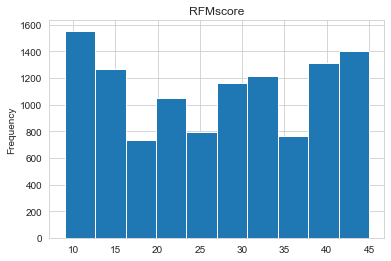

In [16]:
RFM.score.plot.hist()
plt.title('RFMscore')
plt.show()

In [17]:
# 고객 세분화
seg_map = {
    r'[1-2][1-2]': 'iron',
    r'[1-2][3-5]': 'bronze',
    r'[3-4][1-3]': 'silver',
    r'3[3-4]' : 'silver',
    r'35' : 'gold',
    r'4[3-4]': 'gold',
    r'45': 'platinum',
    r'51' : 'gold',
    r'5[2-3]' : 'platinum',
    r'5[4-5]' : 'diamond'
}
RFM['segment'] = RFM['M'].map(str) + RFM['F'].map(str)
RFM['segment'] = RFM['segment'].replace(seg_map, regex=True)
RFM.head()

,clnt_id,recency,frequency,monetary,R,F,M,group,score,segment
0,2,32,6,157100,2,3,2,232,21,bronze
1,9,17,7,339941,3,3,3,333,27,silver
2,12,38,1,29900,2,1,1,211,11,iron
3,20,1,7,238580,5,3,3,533,31,silver
4,23,3,9,202964,5,4,3,543,34,silver


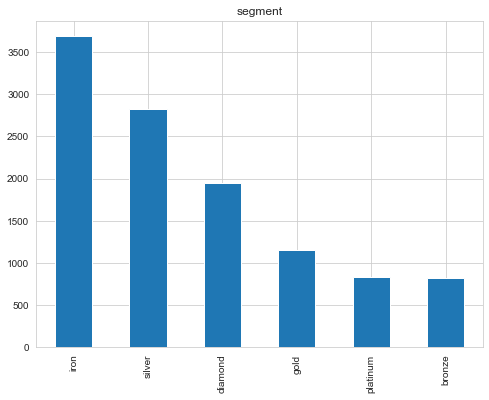

In [18]:
# 세그먼트 별 고객수
plt.figure(figsize=(8,6))
RFM.segment.value_counts().plot.bar()
plt.title('segment')
plt.show()

# Feature

In [19]:
features = pd.DataFrame({'clnt_id': df.clnt_id.unique()}); features

,clnt_id
0,21922
1,39423
2,18362
3,48969
4,18478
...,...
11261,15146
11262,53632
11263,58443
11264,21232


In [21]:
f = RFM[['clnt_id','segment','frequency', 'monetary']];f
features = features.merge(f, how='left'); features

,clnt_id,segment,frequency,monetary
0,21922,bronze,6,79980
1,39423,diamond,23,676262
2,18362,diamond,22,802720
3,48969,gold,12,388898
4,18478,diamond,17,1998300
...,...,...,...,...
11261,15146,iron,1,52800
11262,53632,iron,1,77040
11263,58443,silver,1,568000
11264,21232,silver,1,362500


In [22]:
# 최대구매액, 평균구매액
f = df.groupby('clnt_id')['buy_am'].agg([
    ('최대구매액', np.max),
    ('평균구매액', lambda x: np.round(np.mean(x)))
]).reset_index();
features = features.merge(f, how='left'); features

,clnt_id,segment,frequency,monetary,최대구매액,평균구매액
0,21922,bronze,6,79980,13900,6152
1,39423,diamond,23,676262,55600,5047
2,18362,diamond,22,802720,55600,6861
3,48969,gold,12,388898,25800,3889
4,18478,diamond,17,1998300,711000,62447
...,...,...,...,...,...,...
11261,15146,iron,1,52800,52800,52800
11262,53632,iron,1,77040,77040,77040
11263,58443,silver,1,568000,568000,568000
11264,21232,silver,1,362500,362500,362500


In [23]:
# 내점일수, 구매주기
f= df.groupby('clnt_id')['de_dt'].agg([
    ('내점일수', lambda x : x.nunique()),
    ('구매주기', lambda x : int(((x.max() - x.min()).days) / x.nunique()))
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,segment,frequency,monetary,최대구매액,평균구매액,내점일수,구매주기
0,21922,bronze,6,79980,13900,6152,5,16
1,39423,diamond,23,676262,55600,5047,19,4
2,18362,diamond,22,802720,55600,6861,20,4
3,48969,gold,12,388898,25800,3889,10,8
4,18478,diamond,17,1998300,711000,62447,12,6
...,...,...,...,...,...,...,...,...
11261,15146,iron,1,52800,52800,52800,1,0
11262,53632,iron,1,77040,77040,77040,1,0
11263,58443,silver,1,568000,568000,568000,1,0
11264,21232,silver,1,362500,362500,362500,1,0


In [24]:
# 주구매시간
df['구매시간']=df.de_tm.apply(lambda x : x.split(':')[0]);df.head()
f = df.groupby('clnt_id')[['구매시간']].agg(lambda x: x.value_counts().index[0]).reset_index().rename({'구매시간':'주구매시간'},axis='columns')
features = features.merge(f, how='left'); features

,clnt_id,segment,frequency,monetary,최대구매액,평균구매액,내점일수,구매주기,주구매시간
0,21922,bronze,6,79980,13900,6152,5,16,21
1,39423,diamond,23,676262,55600,5047,19,4,15
2,18362,diamond,22,802720,55600,6861,20,4,10
3,48969,gold,12,388898,25800,3889,10,8,10
4,18478,diamond,17,1998300,711000,62447,12,6,10
...,...,...,...,...,...,...,...,...,...
11261,15146,iron,1,52800,52800,52800,1,0,10
11262,53632,iron,1,77040,77040,77040,1,0,10
11263,58443,silver,1,568000,568000,568000,1,0,10
11264,21232,silver,1,362500,362500,362500,1,0,01


In [25]:
# 거래당 구매건수
frequency = df.groupby('clnt_id')['trans_id'].agg(lambda x: x.nunique())
f = (df.groupby('clnt_id')['buy_am'].count() / frequency).round(1).reset_index().rename(columns={0:'거래당구매건수'})
features = features.merge(f, how='left'); features

,clnt_id,segment,frequency,monetary,최대구매액,평균구매액,내점일수,구매주기,주구매시간,거래당구매건수
0,21922,bronze,6,79980,13900,6152,5,16,21,2.2
1,39423,diamond,23,676262,55600,5047,19,4,15,5.8
2,18362,diamond,22,802720,55600,6861,20,4,10,5.3
3,48969,gold,12,388898,25800,3889,10,8,10,8.3
4,18478,diamond,17,1998300,711000,62447,12,6,10,1.9
...,...,...,...,...,...,...,...,...,...,...
11261,15146,iron,1,52800,52800,52800,1,0,10,1.0
11262,53632,iron,1,77040,77040,77040,1,0,10,1.0
11263,58443,silver,1,568000,568000,568000,1,0,10,1.0
11264,21232,silver,1,362500,362500,362500,1,0,01,1.0


In [26]:
def f(x):
    if x == 'A01' or x == 'A02' or x == 'A03':
        return '온라인'
    else:
        return '오프라인'
df['구매방식']=df['biz_unit'].apply(f);df

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3,구매시간,구매방식
0,21922,104999,3,A03,0182,2019-09-20,12:41,10900,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups,12,온라인
1,39423,105124,10,A03,0182,2019-09-20,17:26,21800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups,17,온라인
2,39423,89469,2,A03,0182,2019-09-01,03:32,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups,03,온라인
3,39423,88436,1,A03,0182,2019-08-30,17:15,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups,17,온라인
4,18362,50872,3,A03,0182,2019-07-15,09:46,31600,4,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups,09,온라인
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582304,53632,75835,1,A01,0258,2019-08-14,10:00,77040,2,M,50,Computers,Computer Accessories,Printer Inks / Toners,10,온라인
582305,1499,92574,4,A01,1303,2019-09-04,08:09,29000,1,F,50,Sport Fashion,Women's Climbing Clothing,Women's Climbing Vests,08,온라인
582306,58443,103525,1,A01,0263,2019-09-18,10:30,568000,1,F,30,Computers,Computers / Laptops,Tablet PCs,10,온라인
582307,21232,103476,1,A01,0263,2019-09-18,01:38,362500,1,F,30,Computers,Computers / Laptops,Tablet PCs,01,온라인


In [27]:
f = df.groupby('clnt_id')[['구매방식']].agg(lambda x : x.value_counts().index[0]).reset_index().rename({'구매방식':'주구매방식'},axis='columns')
features = features.merge(f, how='left'); features

,clnt_id,segment,frequency,monetary,최대구매액,평균구매액,내점일수,구매주기,주구매시간,거래당구매건수,주구매방식
0,21922,bronze,6,79980,13900,6152,5,16,21,2.2,온라인
1,39423,diamond,23,676262,55600,5047,19,4,15,5.8,온라인
2,18362,diamond,22,802720,55600,6861,20,4,10,5.3,온라인
3,48969,gold,12,388898,25800,3889,10,8,10,8.3,온라인
4,18478,diamond,17,1998300,711000,62447,12,6,10,1.9,온라인
...,...,...,...,...,...,...,...,...,...,...,...
11261,15146,iron,1,52800,52800,52800,1,0,10,1.0,온라인
11262,53632,iron,1,77040,77040,77040,1,0,10,1.0,온라인
11263,58443,silver,1,568000,568000,568000,1,0,10,1.0,온라인
11264,21232,silver,1,362500,362500,362500,1,0,01,1.0,온라인


In [28]:
f = df.groupby('clnt_id')['de_dt'].agg([
    ('주말방문율', lambda x: (x.dt.weekday > 4).mean().round(1)),
    ('평일방문율', lambda x: (x.dt.weekday <= 4).mean().round(1))
     ]).reset_index();f
features = features.merge(f, how='left'); features

,clnt_id,segment,frequency,monetary,최대구매액,평균구매액,내점일수,구매주기,주구매시간,거래당구매건수,주구매방식,주말방문율,평일방문율
0,21922,bronze,6,79980,13900,6152,5,16,21,2.2,온라인,0.0,1.0
1,39423,diamond,23,676262,55600,5047,19,4,15,5.8,온라인,0.1,0.9
2,18362,diamond,22,802720,55600,6861,20,4,10,5.3,온라인,0.0,1.0
3,48969,gold,12,388898,25800,3889,10,8,10,8.3,온라인,0.0,1.0
4,18478,diamond,17,1998300,711000,62447,12,6,10,1.9,온라인,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,15146,iron,1,52800,52800,52800,1,0,10,1.0,온라인,0.0,1.0
11262,53632,iron,1,77040,77040,77040,1,0,10,1.0,온라인,0.0,1.0
11263,58443,silver,1,568000,568000,568000,1,0,10,1.0,온라인,0.0,1.0
11264,21232,silver,1,362500,362500,362500,1,0,01,1.0,온라인,0.0,1.0


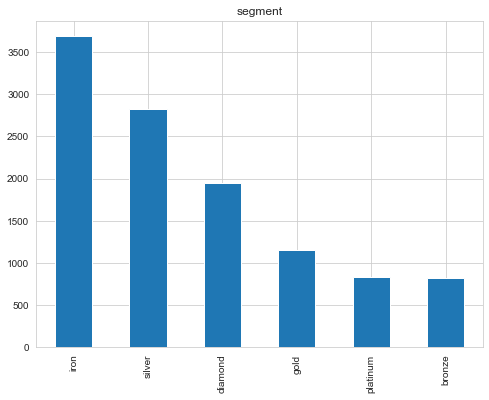

In [29]:
plt.figure(figsize=(8,6))
RFM.segment.value_counts().plot.bar()
plt.title('segment')
plt.show()

# iron의 수가 제일 많은 것을 확인할 수 있다. 그래서 iron의 사람들을 bronze, silver로 올리는 전략을 선택

In [124]:
f = features.query('segment== "iron" or segment== "bronze" or segment== "silver" ')
i = pd.DataFrame({'segment': f.segment.unique()}); i

,segment
0,bronze
1,silver
2,iron


In [125]:
# 평균최대구매액
k = f.groupby('segment')['최대구매액'].agg(lambda x : round(np.mean(x))).reset_index().rename({'최대구매액':'평균최대구매액'},axis='columns')
i = i.merge(k, how='left'); i

,segment,평균최대구매액
0,bronze,25512
1,silver,94307
2,iron,37614


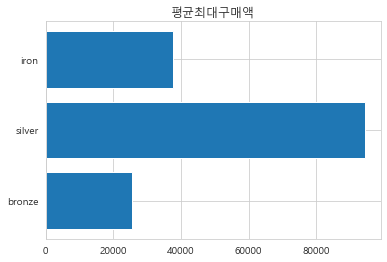

In [126]:
x = i['segment']
y = i['평균최대구매액']

plt.barh(x,y)
plt.title('평균최대구매액')
plt.show()

In [127]:
k = f.groupby('segment')['monetary'].agg(lambda x: round(np.mean(x))).reset_index().rename({'monetary':'평균총구매비용'},axis='columns')
i = i.merge(k, how='left'); i

,segment,평균최대구매액,평균총구매비용
0,bronze,25512,129104
1,silver,94307,309649
2,iron,37614,76538


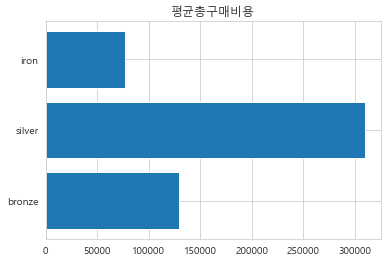

In [130]:
x = i['segment']
y = i['평균총구매비용']

plt.barh(x,y)
plt.title('평균총구매비용')
plt.show()

In [131]:
k = f.groupby('segment')['내점일수'].agg(lambda x: round(np.mean(x))).reset_index().rename({'내점일수':'평균내점일수'},axis='columns')
i = i.merge(k, how='left');i


,segment,평균최대구매액,평균총구매비용,평균내점일수
0,bronze,25512,129104,7
1,silver,94307,309649,5
2,iron,37614,76538,2


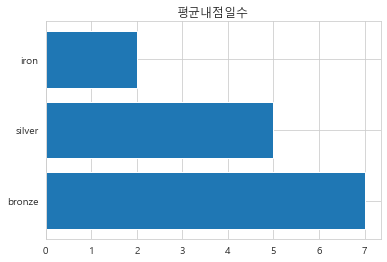

In [132]:
x = i['segment']
y = i['평균내점일수']

plt.barh(x,y)
plt.title('평균내점일수')
plt.show()

In [133]:
# 주 구매시간
k = f.groupby('segment')[['주구매시간']].agg(lambda x: x.value_counts().index[0]).reset_index()
i = i.merge(k, how='left'); i

,segment,평균최대구매액,평균총구매비용,평균내점일수,주구매시간
0,bronze,25512,129104,7,19
1,silver,94307,309649,5,11
2,iron,37614,76538,2,12


In [134]:
# 평일, 주말 방문율
k = f.groupby('segment')['주말방문율'].mean().reset_index()
i = i.merge(k, how='left'); i

,segment,평균최대구매액,평균총구매비용,평균내점일수,주구매시간,주말방문율
0,bronze,25512,129104,7,19,0.244756
1,silver,94307,309649,5,11,0.285340
2,iron,37614,76538,2,12,0.258883


In [135]:
k = f.groupby('segment')['평일방문율'].mean().reset_index()
i = i.merge(k, how='left'); i

,segment,평균최대구매액,평균총구매비용,평균내점일수,주구매시간,주말방문율,평일방문율
0,bronze,25512,129104,7,19,0.244756,0.755244
1,silver,94307,309649,5,11,0.285340,0.714660
2,iron,37614,76538,2,12,0.258883,0.741117


In [136]:
# 평군거래당 구매건수
k = f.groupby('segment')['거래당구매건수'].mean().reset_index();
i = i.merge(k, how='left')
i = i.rename({'거래당구매건수':'평균거래당구매건수'},axis='columns');i

,segment,평균최대구매액,평균총구매비용,평균내점일수,주구매시간,주말방문율,평일방문율,평균거래당구매건수
0,bronze,25512,129104,7,19,0.244756,0.755244,3.923902
1,silver,94307,309649,5,11,0.285340,0.714660,5.142033
2,iron,37614,76538,2,12,0.258883,0.741117,3.835259


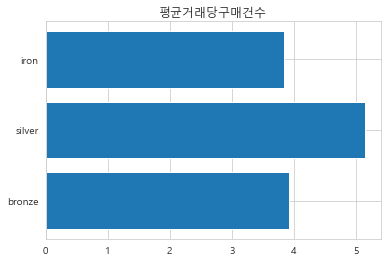

In [137]:
x = i['segment']
y = i['평균거래당구매건수']

plt.barh(x,y)
plt.title('평균거래당구매건수')
plt.show()

In [175]:
k=features.query('segment=="iron"').groupby('주구매시간')['clnt_id'].count().reset_index().rename({'clnt_id':'이용자수'},axis='columns')
k.이용자수.sort_values(ascending = False).head(6).reset_index().rename({'index':'주구매시간'},axis='columns')

,주구매시간,이용자수
0,12,305
1,15,285
2,10,277
3,14,276
4,13,261
5,11,254
